# Generating Text with the Hobbit

One of the cooler tasks in natural language processing is to create a text generator. I love the Hobbit and I love Tolkein, so we'll use his work to create something that'll mimic his writing.

The model that we'll use relies on a Long Short Term Memory architecture (LSTM).

Just to be able to push out a model quicker, I'm just going to use a model that predicts by characters only, rather than words.

## An intro to LSTMs

Essentially, it's a neural network that is able to take previous sequential information into account to generate a smarter output. For text generation, it's able to effectively "remember" previous words to generate additional text. It uses these "memories" to generate a probability for the most likely word to appear, and we pick the word with the highest probability as our prediction.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf

Using TensorFlow backend.


## Data Collection
__Downloaded from [here](https://archive.org/stream/TheHobbitByJ.R.RTolkien/The%20Hobbit%20by%20J.R.R%20Tolkien_djvu.txt)__

Our data is raw text, so that it may easily be processed and such. I'm also going to assume that it's bits and bytes are encoded in `utf-8`.

In [2]:
with open('the-hobbit.txt', 'r', encoding='utf-8') as f_ptr:
    text = f_ptr.read()

len(text)

514754

In [3]:
text[:50]

'Chapter I \n\n\nAN UNEXPECTED PARTY \n\n\nIn a hole in t'

Looking at this data, there's plenty of information that we don't want, such as newlines e.g. `\n`, and useless stuff such as `CHAPTER` and the like such as.

These are easy to get rid of, let's do that.

In [4]:
# Get rid of all newline chars
no_newline = ''.join([chara for chara in text if chara != '\n'])
# Get rid of chapter headings with regex, an important tool in NLP
no_chapter = re.sub(r'Chapter (?=[MDCLXVI])M*(C[MD]|D?C*)(X[CL]|L?X*)(I[XV]|V?I*)', '', no_newline)
# Get rid of chapter titles, which I assume are all ALL CAPS words
no_allcaps = re.sub(r'\s*[A-Z]+\s+', '', no_chapter)

In [5]:
no_allcaps[:400]

'In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort. It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle. The door opened on to a tube-shaped ha'

## Data exploration

This is an easily overlooked part in training a learning model.

If the exploration is well executed, it can help us get intuitions on what the model has learnt, and as such, help us debug the model. It can also tell us whether neural networks are a viable solution for this or whether we could scale it back and use simpler models. 

However, for the sake of saving time, lets just do one very important one.

### Word Frequency

Though we aren't using a word generator to produce sentences, we should still take a careful look though the most frequent words, as these will generally cause a slight bias towards the usage of these words.

### Preparation

In [6]:
def get_word_freqs(text, stop_words=True):
    if stop_words:
        cv = CountVectorizer(input='content', stop_words='english')
    else:
        cv = CountVectorizer(input='content')
    bag_of_words = cv.fit_transform([text])
    sum_words = bag_of_words.sum(axis=0)
    
    word_freqs = [(word, sum_words[0, index]) for word, index in cv.vocabulary_.items()]
    word_freqs = sorted(word_freqs, key = lambda x: x[1], reverse=True)
    
    return word_freqs

def plot_word_freqs(word_freqs, top_n_words=10):
    counts = []
    words = []
    for word, count in word_freqs[:top_n_words]:
        words.append(word)
        counts.append(count)
    pd.Series(counts, index=words).plot.barh()
    plt.xlabel('Counts')
    plt.ylabel('Words')

### Result

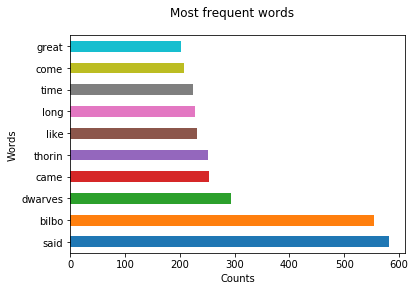

In [7]:
words = get_word_freqs(no_allcaps)
plt.suptitle('Most frequent words')
plot_word_freqs(words)

## Turning the data into a dataframe

In [8]:
chars = sorted(list(set(no_allcaps)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [9]:
seqlen=15
stepsize = 1
X = []
y = []

for i in range(0, len(no_allcaps)-seqlen, stepsize):
    seq = no_allcaps[i: i + seqlen]
    label = no_allcaps[i + seqlen]
    X.append([char_indices[char] for char in seq])
    y.append(char_indices[label])

In [10]:
X[-1]

[47, 44, 0, 59, 54, 41, 40, 42, 42, 54, 7, 49, 40, 57, 8]

In [11]:
seq

'he tobacco-jar.'

In [12]:
label

' '

In [13]:
enc_X = np.reshape(X, (len(X), seqlen, 1))
enc_X = enc_X / float(len(chars))
enc_y = to_categorical(y)

### Creating the model

Keras makes it easy for us to make and deploy models!

The `Sequential` object makes building neural networks like legos. It's the base of the neural network and doesn't do anything by itself.

In [ ]:
model = Sequential()

We then add the layers that we want in the model.

`return_sequences` means that the `LSTM` will also pass it's fed sequence to the next layer. If you look at the `summary` below, it'll show us that there was 3 dimensions being fed, the `15` represents the sentences.

In [ ]:
model.add(LSTM(700, 
               input_shape=(enc_X.shape[1], enc_X.shape[2]), 
               return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(700, 
               input_shape=(enc_X.shape[1], enc_X.shape[2]), 
               return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(700))
model.add(Dropout(0.4))

Finally, we need a softmax layer, which in essence, makes the decision for the next character, by assigning probabilities to each character.

In [ ]:
model.add(Dense(enc_y.shape[1], activation='softmax'))

`categorical crossentropy` is a loss function and loss functions are functions which decide how off we are from the target. These can be changed to suit the particular problem that we are facing, however, the basics will do for us.

Optimizers change the model weights and guide it to a more acceptable loss value.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

We'll take a look at the model in a nutshell.

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 15, 700)           1965600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 700)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15, 700)           3922800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 700)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 71)                49771     
Total para

Let's test it out!

In [14]:
from keras.models import load_model

model = load_model('my_model')

In [17]:
def create_sent(string, length):
    starting = string[:-seqlen]
    string_in = string[-seqlen:]
    created_sent = list(string_in)
    for i in range(length):
        x_i = [char_indices[char]/float(len(chars)) for char in string_in]
        x_i = np.reshape(x_i, (1, seqlen, 1))
        
        pred_index = np.argmax(model.predict(x_i, verbose=0))
        created_sent.append(indices_char[pred_index])
        
        string_in += indices_char[pred_index]
        string_in = string_in[1:seqlen+1]
    
    return starting + ''.join(created_sent)

In [20]:
create_sent('advsdjkvnsknvksnvd', 100)

'advsdjkvnsknvksnvds that he had not been seen that they were all the sight of the dwarves and the stone of the stones '